<center>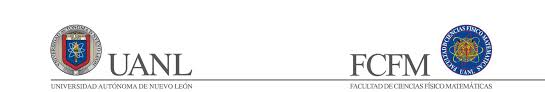  </center>



<h1>  <center>  Aprendizaje Automatizado   </center>    <h1>  

<t1>    <center>    <b> PIA: Modelo de Clasificacion (cross_val_score)  </center>  </t1>

<t1>   <center>   
   <b>   Nombre  </b>    Cynthia  Selene Martínez Espinoza <b>  Matricula   </b> 1011238                            
</center>   </t1>

<h2> Carga de Librerias / funciones </h2>

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, roc_auc_score , roc_curve, DetCurveDisplay, RocCurveDisplay

  
<t3>  1)  carga y exploracion de datos               
<t3>  2)  sacar X , y   
<t3>  3)  separar  secciones X, y  salen X_entrenamiento, y_entrenamiento  
<t3>  4)  seleccionar  y en listar modelos con parametros   
<t3>  5)  usar validacion cruzada con cross_val_score, criterio deroc_auc (con datos estandarizados, de entrenamiento)   
<t3>  6)  evaluar el modelo en el conjunto de prueba, validacion.  </t3>


<h2> Carga y exploracion de datos </h2>

In [2]:
# Leer los datos de archivo csv
url =  "C:/Users/PC/Documents/GitHub/GitFlow-en-Github/ML003/PIA/Practica PIA/prueba.csv"
df_prueba = pd.read_csv(url)

In [3]:
# Leer los datos de archivo csvL
url =  "C:/Users/PC/Documents/GitHub/GitFlow-en-Github/ML003/PIA/Practica PIA/entrenamiento.csv"
df_entrenamiento = pd.read_csv(url)

<h1>  Datos  </h1>
<t3> id	                identificador   
<t3> title_word_count	Conteo de palabra en el Titulo
<t3> document_entropy	aleatoriedad 
<t3> freshness	        Reciente
<t3> easiness	        Facilidad
<t3> fraction_stopword_presence	Palabras Vacias (Fraccion)
<t3> normalization_rate	tasa normalizacion
<t3> speaker_speed	    velocidad altavoz
<t3> silent_period_rate	tasa periodo silencioso
<t3> engagement	        Contrato  </t3>

In [110]:
# Separar características y objetivo en el conjunto de entrenamiento
X = df_entrenamiento.drop(columns=['id', 'engagement','speaker_speed','silent_period_rate','easiness'])
y = df_entrenamiento['engagement'].astype(int)  # Convertir objetivo a entero

In [111]:
# Definir las columnas numéricas
numeric_features = X.columns

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_entrenamiento, X_temp, y_entrenamiento, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val,   X_prueba, y_val,   y_prueba = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [112]:
# Verificar tamaños de los datos
print(f"Tamaño de X_entrenamiento: {X_entrenamiento.shape}, y_entrenamiento: {y_entrenamiento.shape}")
print(f"Tamaño de X_prueba: {X_prueba.shape}, y_temp: {y_temp.shape}")

Tamaño de X_entrenamiento: (5543, 5), y_entrenamiento: (5543,)
Tamaño de X_prueba: (1848, 5), y_temp: (3696,)


In [121]:
# Definir los modelos
Modelos = {
    "K-Nearest Neighbors": KNeighborsClassifier(metric='euclidean', n_neighbors=30, weights='distance'),
    "Support Vector Machine": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier()
}

In [114]:
# Configurar StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Iterar sobre cada modelo y calcular el ROC AUC promedio
for nombre_modelo, modelo in Modelos.items():
    # Crear pipeline con el preprocesador y el modelo
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', modelo)
    ])
    # Calcular cross_val_score
    cv_scores = cross_val_score(pipeline, X_entrenamiento, y_entrenamiento, cv=cv, scoring='roc_auc')
    
    # Imprimir resultados
    print(f"Cross-validated ROC AUC for {nombre_modelo}: {cv_scores.mean()}")

Cross-validated ROC AUC for K-Nearest Neighbors: 0.8606671924872391
Cross-validated ROC AUC for Support Vector Machine: 0.7996367417591634
Cross-validated ROC AUC for Decision Tree: 0.6977845310687367


In [115]:
# Evaluar cada clasificador
resultados = {}
for nombre_modelo, modelo in Modelos.items():

# Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento)

# Validar el modelo
    y_val_pred = modelo.predict(X_val)
    validacion_accuracy = accuracy_score(y_val, y_val_pred)

# Evaluar el modelo en el conjunto de prueba
    y_prueba_pred = modelo.predict(X_prueba)
    prueba_accuracy = accuracy_score(y_prueba, y_prueba_pred)

# Calcular el ROC AUC
    y_pred_proba = modelo.predict_proba(X_prueba)[:, 1]
    roc_auc = roc_auc_score(y_prueba, y_pred_proba)
    
   # resultados
    resultados[nombre_modelo] = {
        "Validacion Accuracy": validacion_accuracy,
        "Prueba  Accuracy": prueba_accuracy,
        "ROC AUC": roc_auc
    }

In [116]:
# Mostrar los resultados
resultados_df = pd.DataFrame(resultados).T
print(resultados_df)

                        Validacion Accuracy  Prueba  Accuracy   ROC AUC
K-Nearest Neighbors                0.913961          0.910173  0.797731
Support Vector Machine             0.902597          0.898268  0.307546
Decision Tree                      0.895563          0.881494  0.643957


<h1>  Graficas  </h1>

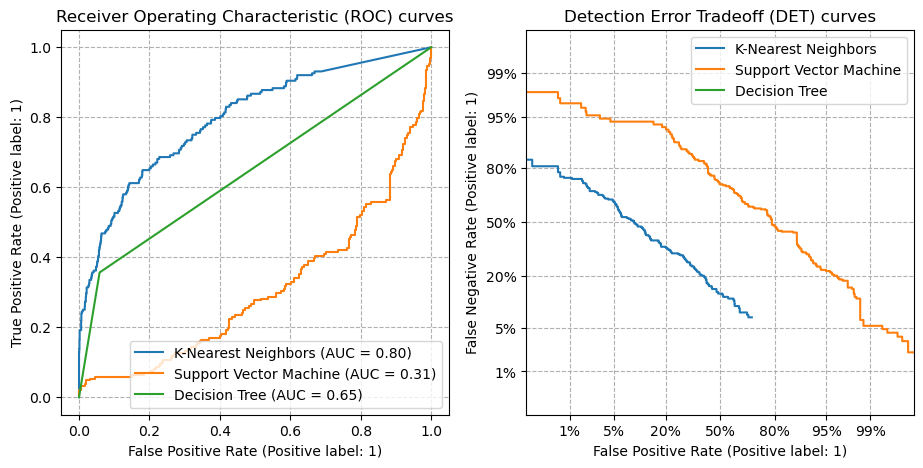

In [139]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in Modelos.items():
    clf.fit(X_entrenamiento, y_entrenamiento)

    RocCurveDisplay.from_estimator(clf, X_prueba, y_prueba, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_prueba, y_prueba, ax=ax_det, name=name)

ax_roc.set_title("Caracteristica operativa recceptor (ROC)")
ax_det.set_title("Compensación de errores de detección (DET)")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.savefig("C:/Users/PC/Documents/GitHub/GitFlow-en-Github/ML003/PIA/Practica PIA/GraficaROC.png")
plt.show()
plt.close()